# 4. Wild fire smoke detection용 yolov8n 모델 pipeline 예제

# IMPORTING LIBRARIES

In [1]:
import sagemaker
import datetime

from botocore.exceptions import NoCredentialsError
from sagemaker.pytorch import PyTorch
from sagemaker.model import ModelPackage
from sagemaker.estimator import Estimator
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.pytorch.processing import PyTorchProcessor
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.pipeline_context import PipelineSession
from sagemaker.workflow.functions import Join
from sagemaker.workflow.lambda_step import LambdaStep
from sagemaker.lambda_helper import Lambda
from sagemaker.workflow.execution_variables import ExecutionVariables
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.model_metrics import ModelMetrics
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.processing import (
    ScriptProcessor, 
    FrameworkProcessor, 
    ProcessingInput, 
    ProcessingOutput
)
from sagemaker.workflow.steps import (
    TrainingStep, 
    ProcessingStep
)
from sagemaker.workflow.lambda_step import (
    LambdaStep,
    LambdaOutput,
    LambdaOutputTypeEnum,
)
from sagemaker.workflow.parameters import ( 
    ParameterInteger, 
    ParameterString, 
    ParameterFloat
)

SAGEMAKER_SESSION = sagemaker.session.Session()
ROLE = sagemaker.get_execution_role()
PIPELINE_SESSION = PipelineSession()
default_bucket = SAGEMAKER_SESSION.default_bucket()

bucket_param = ParameterString(
    name="BucketName",
    default_value=default_bucket
)

folder_name_param = ParameterString(
    name="FolderName",
    default_value=f"YOLOv10-smoke-detection-weights-{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
print(default_bucket)

sagemaker-us-east-1-211125368524


# SETTING UP INPUTS AND IMAGES

In [3]:
s3_bucket_param = ParameterString(name="S3Bucket", default_value=default_bucket)
s3_folder_param = ParameterString(name="S3Folder", default_value="wildfire_smoke")
train_ratio_param = ParameterFloat(name="TrainTestRatio", default_value=0.8)

model_param = ParameterString(name='Model', default_value='yolov8n.pt')
epochs_param = ParameterInteger(name='Epochs', default_value=10)
batch_size_param = ParameterInteger(name='BatchSize', default_value=16)
patience_param = ParameterInteger(name='Patience', default_value=100)
optimizer_param = ParameterString(name='Optimizer', default_value='auto')
ilr_param = ParameterFloat(name='InitialLearningRate', default_value=0.01)
flr_param = ParameterFloat(name='FinalLearningRate', default_value=0.01)

mAP_threshold = ParameterFloat(name='mAPThreshold', default_value=0.75)
mAP50_threshold = ParameterFloat(name='mAP50Threshold', default_value=0.90)
mAP75_threshold = ParameterFloat(name='mAP75Threshold', default_value=0.80)
precisionthreshold = ParameterFloat(name='PrecisionThreshold', default_value=0.90)
recallthreshold = ParameterFloat(name='RecallThreshold', default_value=0.80)
model_package_name = ParameterString(name="ModelPackageName", default_value='yolo-smoke-detection')


PROCESSING_IMAGE = sagemaker.image_uris.retrieve(framework='pytorch', 
                                          region=SAGEMAKER_SESSION.boto_region_name, 
                                          version='2.2.0', 
                                          py_version='py310',
                                          instance_type='ml.m5.2xlarge',
                                          image_scope='training')

TRAINING_IMAGE = sagemaker.image_uris.retrieve(framework='pytorch', 
                                          region=SAGEMAKER_SESSION.boto_region_name, 
                                          version='2.2.0', 
                                          py_version='py310', 
                                          instance_type='ml.m5.xlarge',#'ml.c2.2xlarge',
                                          image_scope='training')

# PRE-PROCESSING STEP

https://public.roboflow.com/object-detection/wildfire-smoke/1

상기 URL에 접속하여 데이터셋을 다운로드합니다.

하기 화면의 오른쪽 상단의 Download 버튼을 클릭합니다.
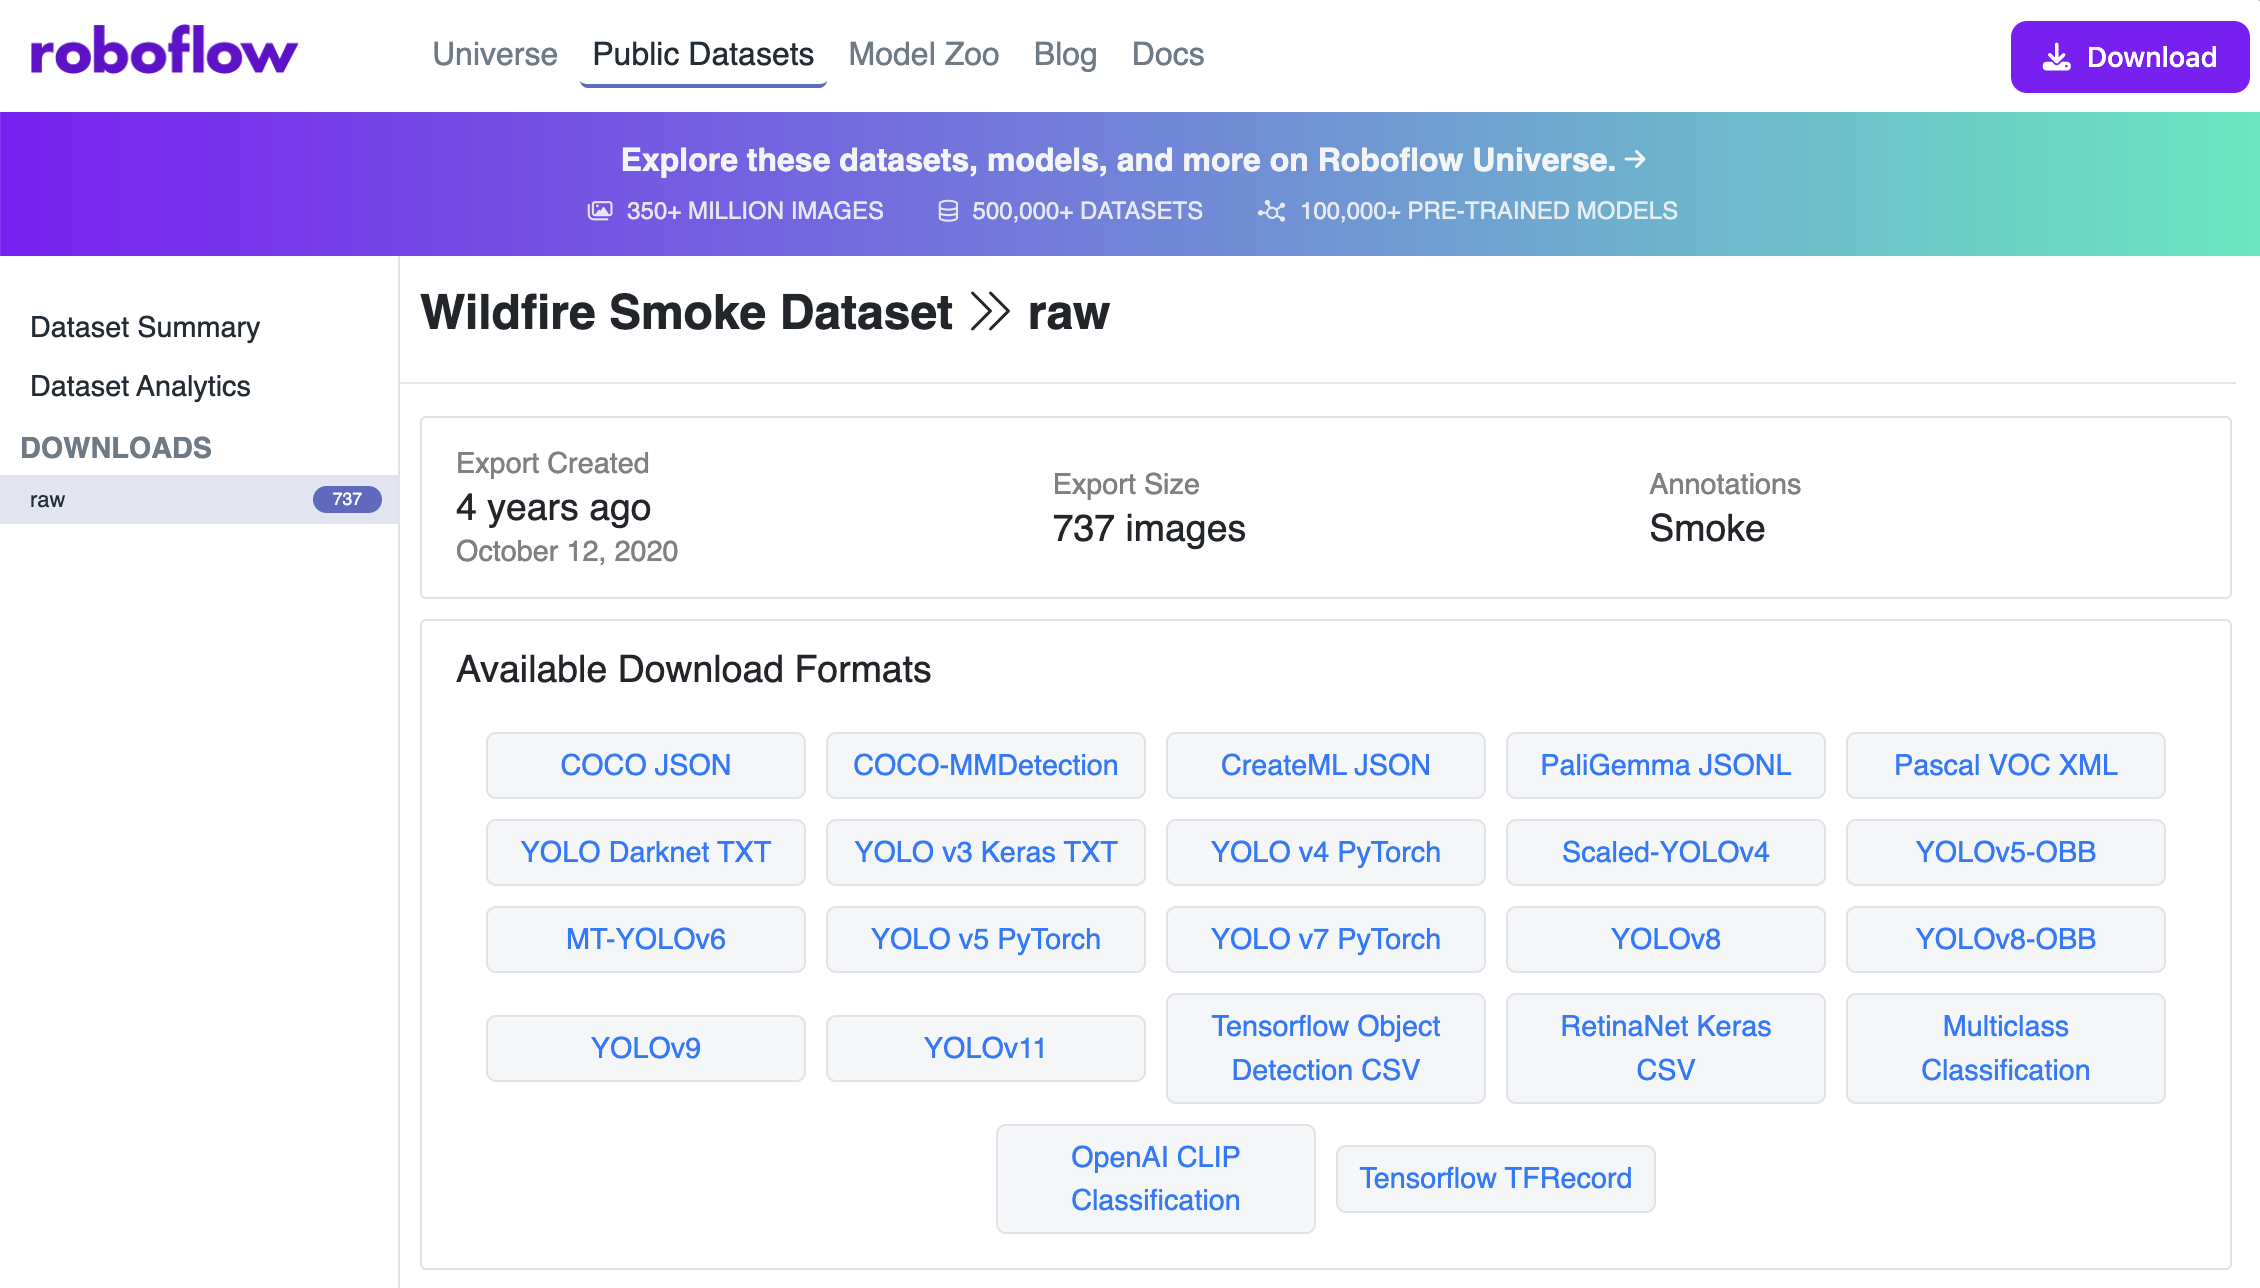

continue 버튼을 클릭하여, 데이터셋 압축파일을 다운로드합니다.
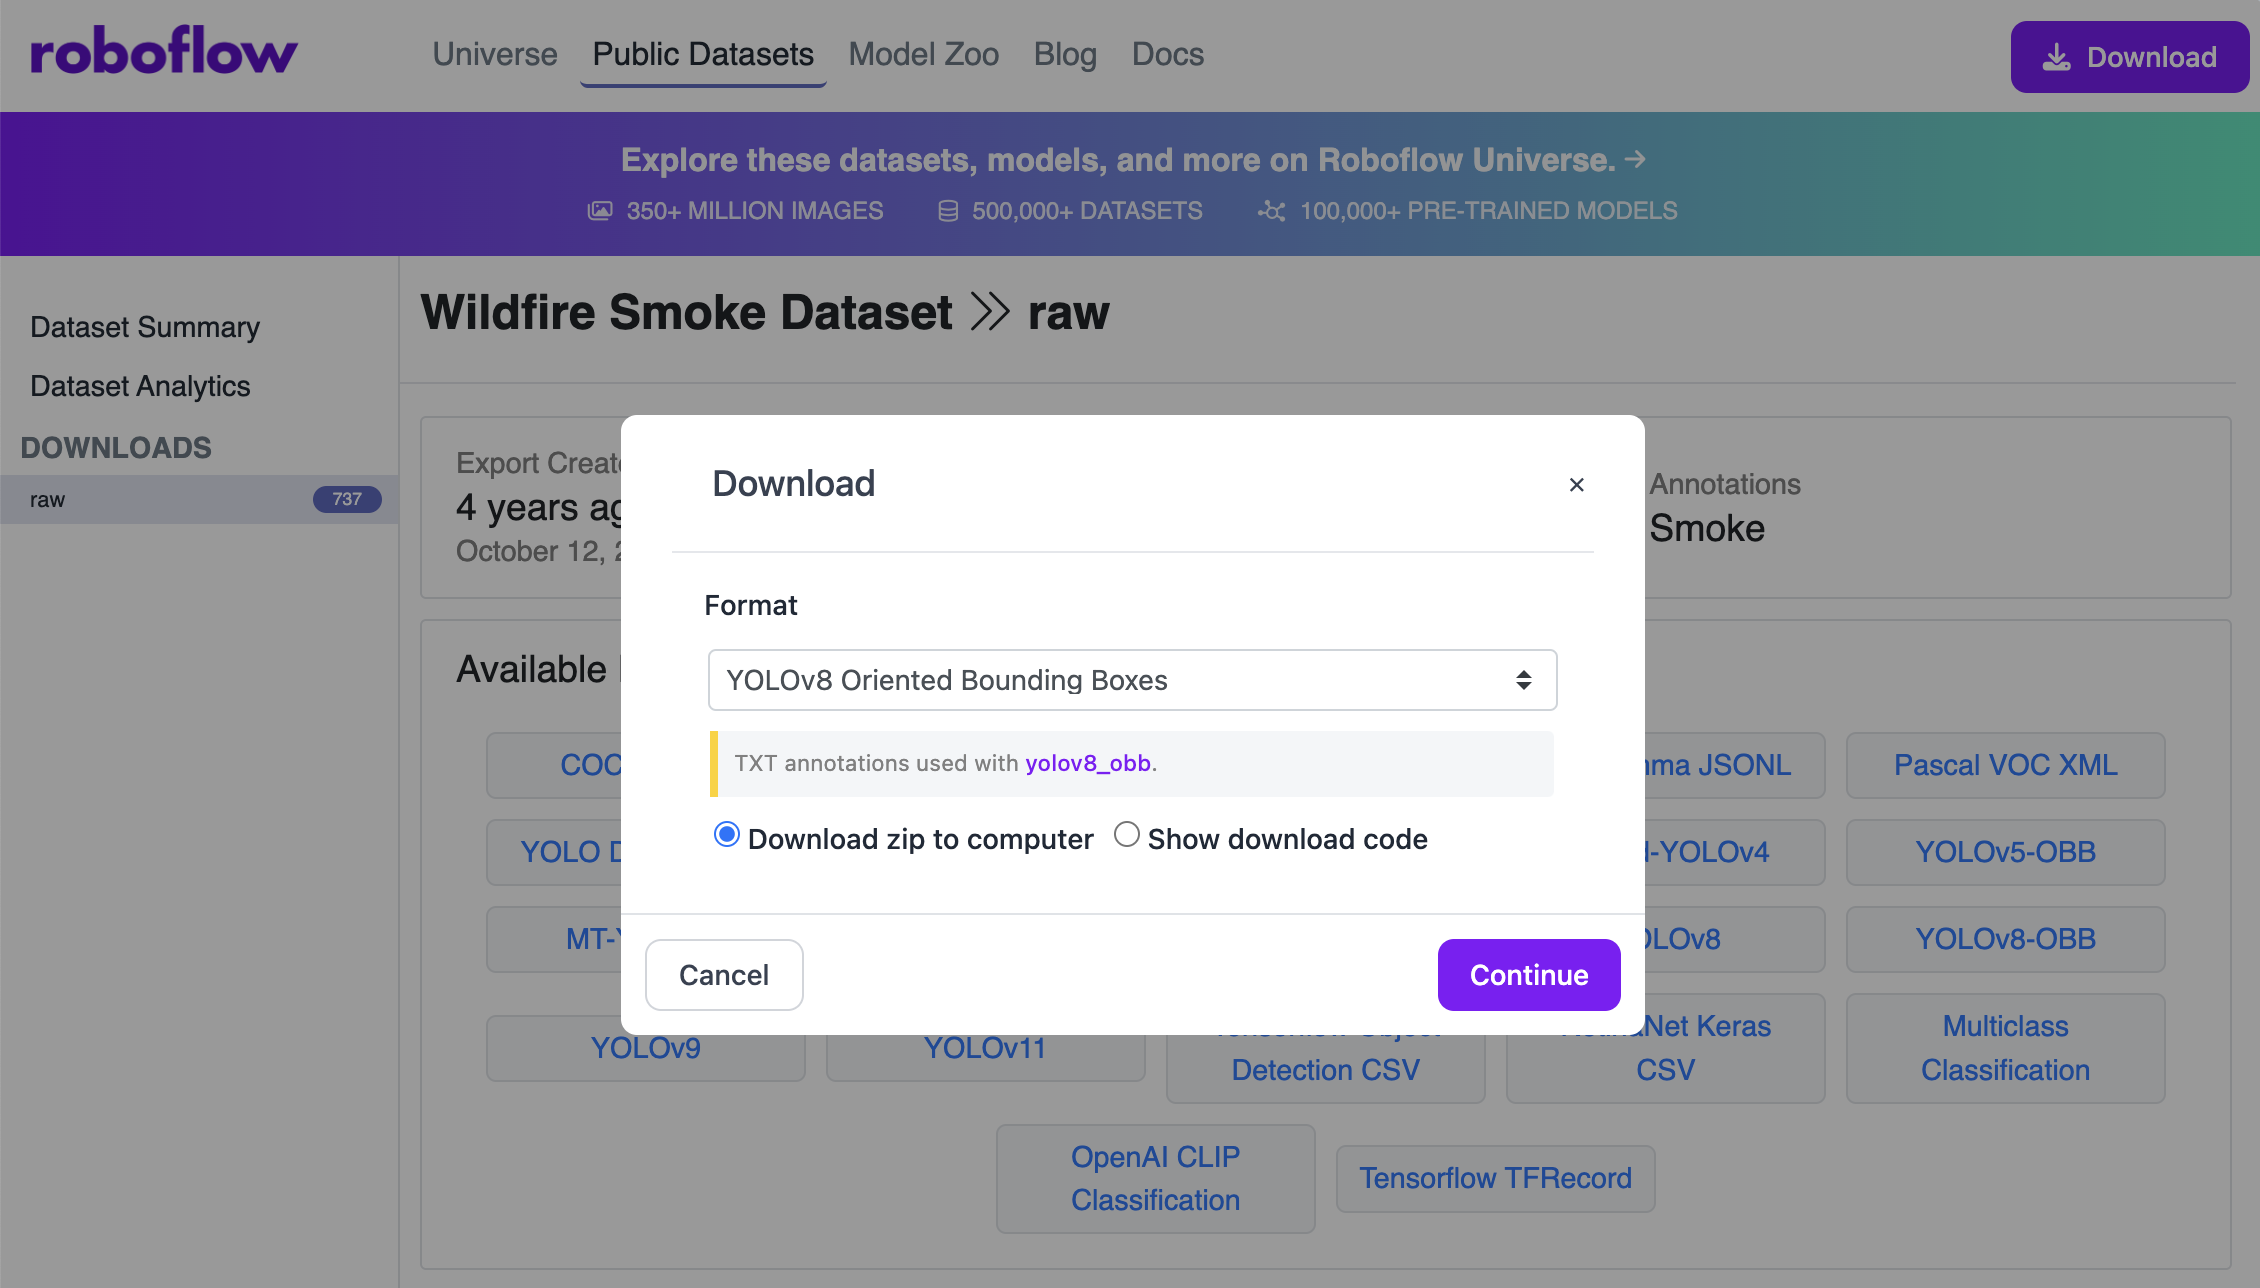

다운받은 압축파일을 작업경로 내에 업로드합니다.

In [4]:
import os
import boto3
import logging
from pathlib import Path
import zipfile

# zip 파일 경로
zip_path = 'Wildfire Smoke.v1-raw.yolov8-obb.zip'

folder_path = "wildfire_smoke/"
os.makedirs(folder_path, exist_ok=True)

# 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)  # 현재 디렉토리에 압축 해제

In [5]:
def check_s3_prefix_exists(bucket_name, s3_prefix):
    s3_client = boto3.client('s3')
    try:
        # List objects with the given prefix
        response = s3_client.list_objects_v2(
            Bucket=bucket_name,
            Prefix=s3_prefix,
            MaxKeys=1
        )
        # If 'Contents' exists in response, the prefix exists and has objects
        return 'Contents' in response
    except Exception as e:
        print(f"Error checking S3 prefix: {str(e)}")
        return False
        
def upload_directory_to_s3(local_directory, bucket_name, s3_prefix):
    # First check if prefix exists
    if check_s3_prefix_exists(bucket_name, s3_prefix):
        print(f"S3 prefix '{s3_prefix}' already exists in bucket '{bucket_name}'. Skipping upload.")
        return
        
    s3_client = boto3.client('s3')
    
    # 로컬 디렉토리 내 모든 파일 순회
    for root, dirs, files in os.walk(local_directory):
        for filename in files:
            # 로컬 파일의 전체 경로
            local_path = os.path.join(root, filename)
            
            # S3에 저장될 경로 생성
            relative_path = os.path.relpath(local_path, local_directory)
            s3_path = os.path.join(s3_prefix, relative_path).replace("\\", "/")
            
            # 업로드 진행
            try:
                print(f"Uploading {local_path} to {bucket_name}/{s3_path}")
                s3_client.upload_file(local_path, bucket_name, s3_path)
            except Exception as e:
                print(f"Error uploading {local_path}: {str(e)}")

# 사용 예시
if __name__ == "__main__":
    # 설정
    LOCAL_DIR = "wildfire_smoke/"  # 업로드할 로컬 디렉토리
    #BUCKET_NAME = "sagemaker-us-east-1-211125368524"           # S3 버킷 이름
    S3_PREFIX = "wildfire_smoke"              # S3 내 저장될 경로
    
    # 업로드 실행
    upload_directory_to_s3(LOCAL_DIR, default_bucket, S3_PREFIX)

S3 prefix 'wildfire_smoke' already exists in bucket 'sagemaker-us-east-1-211125368524'. Skipping upload.


In [6]:
script_processor = ScriptProcessor(
    image_uri=PROCESSING_IMAGE,
    command=['python3'],
    role=ROLE,
    instance_count=1,
    instance_type='ml.t3.xlarge',
    sagemaker_session=SAGEMAKER_SESSION
)

processing_step = ProcessingStep(
    name='YOLO-Preprocessing',
    processor=script_processor,
    inputs=[
        ProcessingInput(
            source=Join(on='/', values=["s3:/", s3_bucket_param, s3_folder_param]),
            destination='/opt/ml/processing/input'
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name='train_data',
            source='/opt/ml/processing/train',
            destination=Join(on='/', values=["s3:/", s3_bucket_param, s3_folder_param, "train"])
        ),
        ProcessingOutput(
            output_name='val_data',
            source='/opt/ml/processing/val',
            destination=Join(on='/', values=["s3:/", s3_bucket_param, s3_folder_param, "val"])
        ),
        ProcessingOutput(
            output_name='test_data',
            source='/opt/ml/processing/test',
            destination=Join(on='/', values=["s3:/", s3_bucket_param, s3_folder_param, "test"])
        )
    ],
    code='yolo_code/smoke_preprocess.py',
    job_arguments=[
        '--s3-bucket', s3_bucket_param.to_string(),
        '--s3-folder', s3_folder_param.to_string(),
        '--train-ratio', train_ratio_param.to_string()
    ]
)


# TRAINING STEP

In [7]:
S3_MODEL_REGISTRY_PATH = f"s3://{default_bucket}/packaged-models/"

training_estimator = Estimator(image_uri=TRAINING_IMAGE,
                      role=ROLE,
                      entry_point='yolo_code/smoke_train.py',
                      instance_count=1,
                      instance_type='ml.m5.xlarge',#'ml.m5.2xlarge',
                      hyperparameters={
                          'model': model_param,
                          'epochs': epochs_param,
                          'batch': batch_size_param,
                          'patience': patience_param,
                          'optimizer': optimizer_param,
                          'initial_learning_rate': ilr_param,
                          'final_learning_rate': flr_param,
                          'bucket_name': bucket_param,
                          'folder_name': folder_name_param
                      },
                      output_path=S3_MODEL_REGISTRY_PATH,
                      sagemaker_session=SAGEMAKER_SESSION,
                      source_dir=".")

training_step = TrainingStep(
    name="YOLO-Training",
    estimator=training_estimator,
    inputs={
        "train": TrainingInput(
            s3_data=processing_step.properties.ProcessingOutputConfig.Outputs['train_data'].S3Output.S3Uri,
            content_type="application/x-recordio"
        ),
        "val": TrainingInput(
            s3_data=processing_step.properties.ProcessingOutputConfig.Outputs['val_data'].S3Output.S3Uri,
            content_type="application/x-recordio"
        )
    }
)

# EVALUATION STEP

In [8]:
MODEL_EVALUTION_PATH = f"s3://{default_bucket}"
EVALUATION_METRICS_FOLDER = f"val-results-{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"

script_eval = FrameworkProcessor(
    estimator_cls=PyTorch,
    framework_version='2.2.0',
    py_version='py310',
    instance_type='ml.t3.xlarge',
    instance_count=1,
    base_job_name='YOLO-Evaluation',
    role=ROLE,
    sagemaker_session=PIPELINE_SESSION,
)

eval_args = script_eval.run(
    inputs=[
        ProcessingInput(
            source=training_step.properties.ModelArtifacts.S3ModelArtifacts,
            destination='/opt/ml/processing/model',
        ),
        ProcessingInput(
            source=processing_step.properties.ProcessingOutputConfig.Outputs['test_data'].S3Output.S3Uri,
            destination='/opt/ml/processing/input'
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name='evaluation',
            source='/opt/ml/processing/evaluation',
            destination=f'{MODEL_EVALUTION_PATH}/{EVALUATION_METRICS_FOLDER}'
        )
    ],
    code='yolo_code/smoke_evaluate.py'
)

evaluation_step = ProcessingStep(
    name='YOLO-Evaluation',
    step_args=eval_args,
    property_files=[PropertyFile(    # Correct parameter name and wrap PropertyFile in a list
        name="EvaluationReport",
        output_name="evaluation",
        path="metrics.json"
    )]
)



INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
/opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


# STEP FOR CONDITIONAL MODEL REGISTRY PUSH

In [9]:
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.functions import Join

mAP_threshold = 0.4

fail_step = FailStep(
    name="mAPFail",
    error_message=Join(on=" ", values=["Execution failed due to mAP <", mAP_threshold]),
)

In [10]:
METRICS_PATH = f's3://{MODEL_EVALUTION_PATH}/{EVALUATION_METRICS_FOLDER}/metrics.json'

register_estimator = Estimator(image_uri=PROCESSING_IMAGE,
                      role=ROLE,
                      instance_count=1,
                      instance_type='ml.t3.medium',
                      sagemaker_session=SAGEMAKER_SESSION
                     )

register_model_step = RegisterModel(
    name="YOLOModelRegistry",
    estimator=register_estimator,
    model_data=training_step.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["application/json"],
    response_types=["application/json"],
    inference_instances=["ml.m5.large"],
    transform_instances=["ml.m5.large"],
    model_package_group_name=model_package_name,
    approval_status="PendingManualApproval",
    #approval_status="Approved",  # Add this line
    description=f"Model metrics available at {METRICS_PATH}"
)

In [11]:
# yolo_code/inference.py 생성
import os
os.makedirs('yolo_code', exist_ok=True)

with open('yolo_code/inference.py', 'w') as f:
    f.write('''#!/bin/bash

# Python 환경 업그레이드
pip install --upgrade pip
pip install --upgrade setuptools wheel

# 필요한 패키지 설치
pip install torch
pip install "ultralytics>=8.0.0" --no-cache-dir

python3 << EOF
import os
import json
import logging
from ultralytics import YOLO

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def process_images():
    try:
        # Define paths
        input_path = '/opt/ml/processing/input'
        model_path = '/opt/ml/processing/model'
        output_path = '/opt/ml/processing/inference_output'

        # Extract the model file from tar.gz
        import tarfile
        tar_files = [f for f in os.listdir(model_path) if f.endswith('.tar.gz')]
        if tar_files:
            with tarfile.open(os.path.join(model_path, tar_files[0])) as tar:
                tar.extractall(model_path)
        
        # Look for .pt file after extraction
        model_files = [f for f in os.listdir(model_path) if f.endswith('.pt')]
        if not model_files:
            raise FileNotFoundError("No .pt file found in model directory")
        model = YOLO(os.path.join(model_path, model_files[0]))
  
        # Create output directory
        os.makedirs(output_path, exist_ok=True)

        logging.info(f"Contents of input directory: {os.listdir(input_path)}")
        
        # Process all images in input directory
        for image_file in os.listdir(input_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(input_path, image_file)
                logging.info(f"Processing image: {image_file}")
                
                # 모델을 직접 사용하여 예측
                results = model.predict(image_path)
                logging.info(f"Successfully generated predictions for {image_file}")
                
                # Save results
                result_path = os.path.join(output_path, f"{os.path.splitext(image_file)[0]}_results.json")
                with open(result_path, 'w') as f:
                    # Results 객체에서 필요한 정보만 추출하여 딕셔너리로 변환
                    result_dict = {
                        'filename': image_file,
                        'predictions': []
                    }
                    
                    for r in results:
                        boxes = r.boxes
                        prediction = {
                            'boxes': boxes.xyxy.tolist() if len(boxes) > 0 else [],
                            'confidence': boxes.conf.tolist() if len(boxes) > 0 else [],
                            'class_ids': boxes.cls.tolist() if len(boxes) > 0 else []
                        }
                        result_dict['predictions'].append(prediction)
                    
                    json.dump(result_dict, f)
                logging.info(f"Saved prediction results for {image_file}")

                # Save the plotted image with detection boxes
                for r in results:
                    im_array = r.plot()  # plot a BGR numpy array of predictions
                    import cv2
                    output_image_path = os.path.join(output_path, f"{os.path.splitext(image_file)[0]}_detected.jpg")
                    cv2.imwrite(output_image_path, im_array)
                logging.info(f"Saved detected image for {image_file}")

        logging.info(f"Inference complete.")
                    
    except Exception as e:
        print(f"Error during inference: {e}")
        raise e

if __name__ == '__main__':
    process_images()
EOF
''')

In [12]:
from sagemaker.workflow.functions import JsonGet
from sagemaker.workflow.pipeline_context import PipelineSession
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.predictor import Predictor
import boto3
from sagemaker.workflow.functions import Join
from sagemaker.workflow.model_step import ModelStep

MODEL_INFERENCE_PATH = f"s3://{default_bucket}"
INFERENCE_METRICS_FOLDER = f"inf-results-{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"

# S3 폴더 생성
s3_client = boto3.client('s3')

# MODEL_INFERENCE_PATH와 INFERENCE_METRICS_FOLDER에 해당하는 S3 경로 생성
try:
    s3_path = f'{MODEL_INFERENCE_PATH}/{INFERENCE_METRICS_FOLDER}'
    # S3 경로에서 버킷 이름과 폴더 경로 분리
    bucket_name = s3_path.split('/')[2]  # s3://bucket-name/... 형식에서 버킷 이름 추출
    folder_path = '/'.join(s3_path.split('/')[3:])  # 버킷 이름 이후의 경로
    
    # 빈 객체를 생성하여 폴더 생성
    s3_client.put_object(
        Bucket=bucket_name,
        Key=(folder_path + '/')
    )
    print(f"Successfully created S3 folder: {s3_path}")
except Exception as e:
    print(f"Error creating S3 folder: {e}")


inference_processor = PyTorchProcessor(
    framework_version='2.0', 
    py_version='py310',
    role=ROLE,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    base_job_name='yolo-inference',
    sagemaker_session=PIPELINE_SESSION
)

inference_step = ProcessingStep(
    name='YOLO-Inference',
    processor=inference_processor,
    inputs=[
        ProcessingInput(
            source=training_step.properties.ModelArtifacts.S3ModelArtifacts,  # Use training artifacts directly
            destination='/opt/ml/processing/model'
        ),
        ProcessingInput(
            source='yolo_code/inference.py',
            destination='/opt/ml/processing/input/code'
        ),
        ProcessingInput(
            source='test_images',#processing_step.properties.ProcessingOutputConfig.Outputs['test_data'].S3Output.S3Uri,
            destination='/opt/ml/processing/input'
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name='inference_results',
            source='/opt/ml/processing/inference_output',
            destination=f'{MODEL_INFERENCE_PATH}/{INFERENCE_METRICS_FOLDER}'
        )
    ],
    code='yolo_code/inference.py',
    depends_on=[register_model_step]
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Successfully created S3 folder: s3://sagemaker-us-east-1-211125368524/inf-results-2025-02-18-13-49-37


In [13]:
from sagemaker.workflow.properties import Properties
from sagemaker.workflow.functions import JsonGet

condition_check = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluation_step.name,
        property_file="EvaluationReport",  # Just use the PropertyFile name as a string
        json_path="mAP"
    ),
    right=mAP_threshold
)

registry_condition_step = ConditionStep(
    name="ModelCheck",
    conditions=[condition_check],
    if_steps=[register_model_step, inference_step],
    else_steps=[fail_step]
)

# SETUP FINAL PIPELINE WITH ALL STEPS AND INPUTS

In [14]:
PIPELINE_NAME = "E2E-Smoke-Detection-Pipeline"

pipeline = Pipeline(
    name=PIPELINE_NAME,
    parameters=[
        bucket_param,  # Add this parameter
        folder_name_param, 
        s3_bucket_param,
        s3_folder_param,
        train_ratio_param,
        model_param,
        epochs_param,
        batch_size_param,
        patience_param,
        optimizer_param,
        ilr_param,
        flr_param,
        mAP_threshold,
        mAP50_threshold,
        mAP75_threshold,
        precisionthreshold,
        recallthreshold,
        model_package_name
    ],
    steps=[
        processing_step, 
        training_step, 
        evaluation_step, 
        registry_condition_step
    ]
)

pipeline.upsert(role_arn=ROLE)

INFO:sagemaker.processing:Uploaded None to s3://sagemaker-us-east-1-211125368524/E2E-Smoke-Detection-Pipeline/code/426062adfd5478d0e509f6c3027e7b73/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-east-1-211125368524/E2E-Smoke-Detection-Pipeline/code/0ff95e6702f0700d1aa530170082a883/runproc.sh
INFO:sagemaker.processing:Uploaded None to s3://sagemaker-us-east-1-211125368524/E2E-Smoke-Detection-Pipeline/code/426062adfd5478d0e509f6c3027e7b73/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-east-1-211125368524/E2E-Smoke-Detection-Pipeline/code/0ff95e6702f0700d1aa530170082a883/runproc.sh


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:211125368524:pipeline/E2E-Smoke-Detection-Pipeline',
 'ResponseMetadata': {'RequestId': '8aeac6a2-0bb7-4e88-8181-b390d90d8f19',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8aeac6a2-0bb7-4e88-8181-b390d90d8f19',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '96',
   'date': 'Tue, 18 Feb 2025 13:49:48 GMT'},
  'RetryAttempts': 0}}

In [15]:
execution = pipeline.start()